# Project 2: Ridge Regression with SGD & Complexity Analysis


### Question I: Deriving the SGD Update with L2 Regularization.

#### 1. Define the Regularized Error Function

For ridge regression, we start with the standard linear regression error function and add an L2 regularization term:

$E_{ridge}(\mathbf{w}) = E(\mathbf{w}) + \lambda ||\mathbf{w}||_2^2$

Where:
- $E(\mathbf{w})$ is the standard mean squared error (MSE) for linear regression
- $\lambda$ is the regularization parameter that controls the strength of regularization
- $||\mathbf{w}||_2^2$ is the squared L2 norm of the weight vector $\mathbf{w}$

Expanding the error term for linear regression with $n$ data points:

$E_{ridge}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2 + \lambda \sum_{j=1}^{d}w_j^2$

Where:
- $n$ is the number of data samples
- $y_i$ is the target value for the $i$-th sample
- $\mathbf{x}_i$ is the feature vector for the $i$-th sample
- $w$ is the weight vector of the model
- $d$ is the dimensionality of the weight vector

#### 2. Compute the Gradient of the Regularized Error Function

To perform gradient descent, we need to compute the gradient of $E_{ridge}$ with respect to $\mathbf{w}$:

$\nabla_{\mathbf{w}} E_{ridge}(\mathbf{w}) = \nabla_{\mathbf{w}} E(\mathbf{w}) + \nabla_{\mathbf{w}}(\lambda ||\mathbf{w}||_2^2)$

First, let's compute the gradient of the standard error term:

$\nabla_{\mathbf{w}} E(\mathbf{w}) = \nabla_{\mathbf{w}} \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2$

Applying the chain rule:

$\nabla_{\mathbf{w}} E(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n} -2(y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i$

Simplifying:

$\nabla_{\mathbf{w}} E(\mathbf{w}) = \frac{-2}{n}\sum_{i=1}^{n} (y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i$

Now, let's compute the gradient of the regularization term:

$\nabla_{\mathbf{w}}(\lambda ||\mathbf{w}||_2^2) = \nabla_{\mathbf{w}}(\lambda \sum_{j=1}^{d}w_j^2) = 2\lambda\mathbf{w}$

Therefore, the gradient of the ridge regression error function is:

$\nabla_{\mathbf{w}} E_{ridge}(\mathbf{w}) = \frac{-2}{n}\sum_{i=1}^{n} (y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i + 2\lambda\mathbf{w}$

#### 3. Weight Update Steps for SGD

For stochastic gradient descent, we update the weights based on a single training example per step. The weight update rule becomes:

$\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla_{\mathbf{w}} E_{ridge,i}(\mathbf{w}_t)$

Where:
- $\eta$ is the learning rate
- $E_{ridge,i}$ is the regularized error for the $i$-th sample

Substituting the gradient:

$\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \left[ -2(y_i - \mathbf{w}_t^T\mathbf{x}_i)\mathbf{x}_i + 2\lambda\mathbf{w}_t \right]$

Simplifying:

$\mathbf{w}_{t+1} = \mathbf{w}_t + 2\eta(y_i - \mathbf{w}_t^T\mathbf{x}_i)\mathbf{x}_i - 2\eta\lambda\mathbf{w}_t$

Further rearranging:

$\mathbf{w}_{t+1} = (1 - 2\eta\lambda)\mathbf{w}_t + 2\eta(y_i - \mathbf{w}_t^T\mathbf{x}_i)\mathbf{x}_i$

This is the final weight update rule for SGD with ridge regression.



### Question II: Ridge Regression Implementation using Gradient Descent

Final Train MSE: 5903.681976
Final Test MSE: 5199.974923


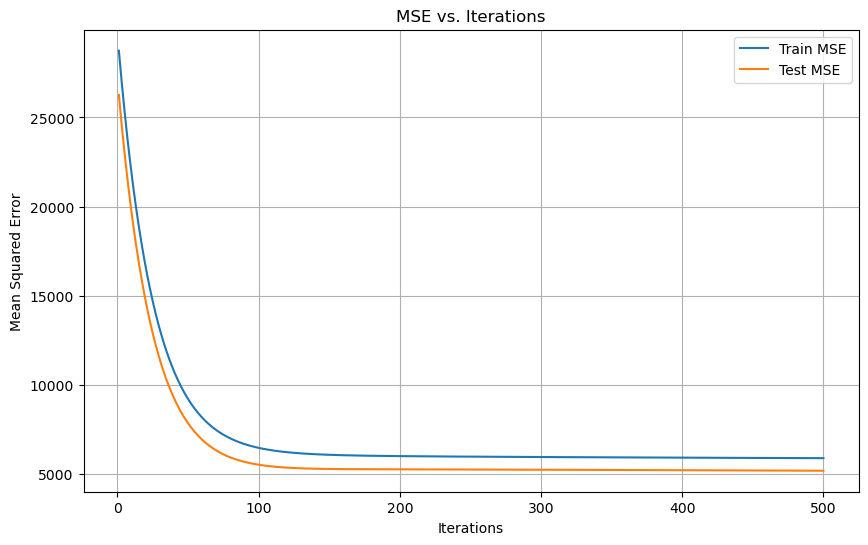

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class RidgeRegression:
    """
    Ridge Regression implementation using gradient descent methods.
    Includes tracking and printing of training and test MSE.
    """
    
    def __init__(self, alpha=1.0, max_iter=1000, learning_rate=0.01, random_state=None):
        """
        Initialize the Ridge Regression model.
        
        Parameters:
        -----------
        alpha : float, default=1.0
            Regularization strength (lambda in the derivation).
        max_iter : int, default=1000
            Maximum number of iterations for gradient descent.
        learning_rate : float, default=0.01
            Learning rate for gradient descent.
        random_state : int, default=None
            Random seed for reproducibility.
        """
        self.alpha = alpha
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.weights = None
        self.intercept = None
        self.n_iter_ = None
        self.train_mse_history = []
        self.test_mse_history = []
        
    def _calculate_mse(self, X, y):
        """
        Calculate Mean Squared Error.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input data.
        y : array-like of shape (n_samples,)
            Target values.
            
        Returns:
        --------
        mse : float
            Mean Squared Error.
        """
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)
    
    def fit(self, X, y, X_test=None, y_test=None):
        """
        Fit the Ridge Regression model using gradient descent.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,)
            Target values.
        X_test : array-like of shape (n_test_samples, n_features), default=None
            Test data for tracking test MSE during training.
        y_test : array-like of shape (n_test_samples,), default=None
            Test target values.
        
        Returns:
        --------
        self : object
            Fitted model.
        """
        # Convert inputs to numpy arrays for numerical calculation
        X = np.array(X)
        y = np.array(y)
        
        # Add intercept term, prepend a column of ones to X, which allows the model to learn a bias term w0. Without this, the regression line would be forced to pass through the origin, which may reduce model accuracy.
        X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
        
        # randomly initialize the weights using a standard normal distribution
        n_features = X_with_intercept.shape[1]
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features)
        
        # Gradient Descent setup
        n_samples = X_with_intercept.shape[0]
        self.n_iter_ = 0
        
        # Full batch gradient descent. Every weight update is based on the entire dataset. This typically results in a stable gradient direction but can be computationally expensive for large datasets.
        batch_size = n_samples
        
        # Reset MSE history
        self.train_mse_history = []
        self.test_mse_history = []
        
        # Gradient descent iterations
        for i in range(self.max_iter):
            X_batch = X_with_intercept
            y_batch = y
            
            # Compute predictions
            y_pred = X_batch @ self.weights
            
            # Compute gradient of loss (MSE part)
            error_gradient = -2 * X_batch.T @ (y_batch - y_pred) / X_batch.shape[0]
            
            # Compute gradient of the L2 regularization term (excluding intercept)
            reg_gradient = np.zeros_like(self.weights)
            reg_gradient[1:] = 2 * self.alpha * self.weights[1:]  # Don't regularize intercept
            
            # Total gradient
            gradient = error_gradient + reg_gradient
            
            # Update weights
            self.weights -= self.learning_rate * gradient
            
            # Track MSE for this iteration
            train_mse = self._calculate_mse(X, y)
            self.train_mse_history.append(train_mse)
            
            if X_test is not None and y_test is not None:
                test_mse = self._calculate_mse(X_test, y_test)
                self.test_mse_history.append(test_mse)
            
            self.n_iter_ = i + 1
        
        # Extract intercept and weights for better interpretability
        self.intercept = self.weights[0]
        self.coef_ = self.weights[1:]
        
        return self
    
    def predict(self, X):
        """
        Predict using the Ridge Regression model.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples.
        
        Returns:
        --------
        y_pred : array-like of shape (n_samples,)
            Predicted values.
        """
        # Ensure model is trained
        if self.weights is None:
            raise ValueError("Model not fitted yet. Call 'fit' first.")

        # Add intercept column to input data
        X = np.array(X)
        X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))

        # Return predicted values
        return X_with_intercept @ self.weights
    
    def plot_mse_history(self):
        """
        Plot the MSE history during training.
        """
        try:
            
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(self.train_mse_history) + 1), self.train_mse_history, label='Train MSE')
            
            if len(self.test_mse_history) > 0:
                plt.plot(range(1, len(self.test_mse_history) + 1), self.test_mse_history, label='Test MSE')
            
            plt.xlabel('Iterations')
            plt.ylabel('Mean Squared Error')
            plt.title('MSE vs. Iterations')
            plt.legend()
            plt.grid(True)
            plt.show()
            
        except ImportError:
            print("Matplotlib is required for plotting. Please install it.")

# Example usage
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Initialize and train model
ridge = RidgeRegression(alpha=0.1, learning_rate=0.01, max_iter=500, random_state=42)
ridge.fit(X_train, y_train, X_test, y_test)

# Final predictions
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Report MSE
print(f"Final Train MSE: {mean_squared_error(y_train, y_pred_train):.6f}")
print(f"Final Test MSE: {mean_squared_error(y_test, y_pred_test):.6f}")

# Visualize training curve
ridge.plot_mse_history()

### Comments on Question II: 

In this section, we implement **Ridge Regression** from scratch using **batch gradient descent** and test it on the **diabetes dataset**. The model includes an L2 regularization term and follows the update rule derived in Question 4.I.

The implementation:
- Adds an intercept term to the data manually.
- Uses the gradient of the regularized loss:
  
  $
  \nabla_{\mathbf{w}} = -\frac{2}{n} X^\top (y - X\mathbf{w}) + 2\lambda \mathbf{w}
  \ $

  with the bias term excluded from regularization.
- Runs for a fixed number of iterations (`max_iter`).
- Tracks and plots training and test MSE over epochs.


#### Training Setup

- **Dataset**: `load_diabetes()` from `sklearn.datasets`
- **Train/Test Split**: 70% training, 30% test
- **Hyperparameters**:
  - `alpha = 0.1` (regularization strength)
  - `learning_rate = 0.01`
  - `max_iter = 500`
- **Batch size**: Full batch (no mini-batch or SGD used)


#### Results

After training for 500 iterations:

- **Train MSE**: _5903.681976_
- **Test MSE**: _5199.974923_

The training and test MSEs converge smoothly, as shown in the plot. The small gap between them indicates a well-regularized model that generalizes effectively to unseen data.


#### MSE vs. Iterations Plot

The plot below shows the Mean Squared Error (MSE) over time for both training and test sets. The convergence behavior confirms that the gradient descent implementation is working correctly and effectively minimizes the loss.


This implementation satisfies all the requirements of **Question 4.II**, demonstrating correct application of Ridge Regression with L2 regularization and a working training pipeline.


### Question III: Analyze Regularization Effect Using Synthetic Data

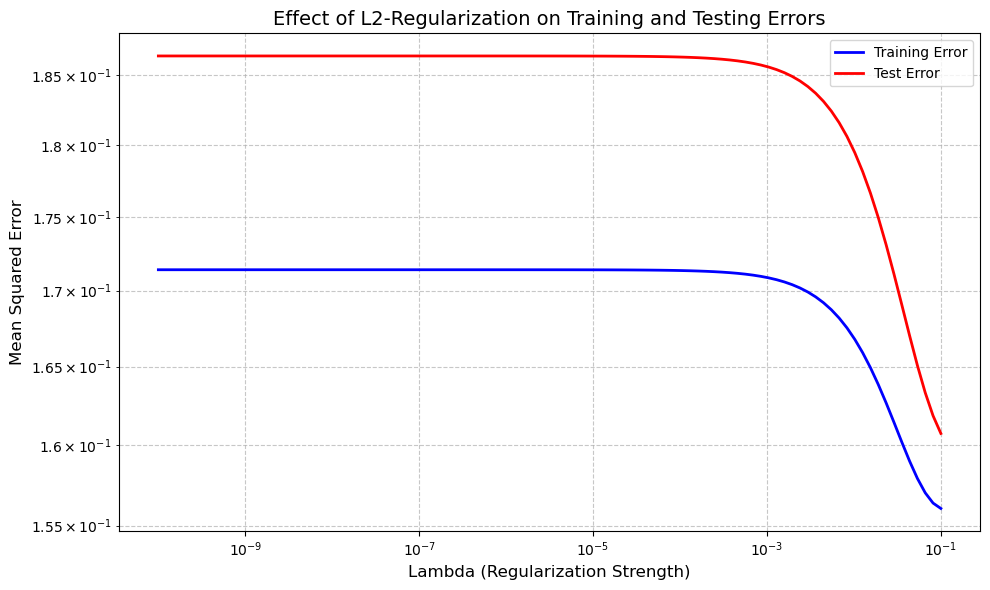

Best lambda value: 0.10000000
Minimum test error: 0.160720


In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Function to generate synthetic data according to the given formula
def generate_synthetic_data(n_samples, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # X ~ Uniform(-0.3, 0.3)
    X = np.random.uniform(-0.3, 0.3, n_samples).reshape(-1, 1)
    
    # Y = cos(3πx)/(2+3x) + ε, where ε ~ N(0, 0.1)
    noise = np.random.normal(0, 0.1, n_samples)
    Y = np.cos(3 * np.pi * X.flatten()) / (2 + 3 * X.flatten()) + noise
    
    return X, Y

# Create range of lambda values as specified in the assignment
lambda_values = np.geomspace(1e-10, 0.1, 101, endpoint=True)

# Parameters
n_repetitions = 10  # Number of repetitions with different training sets
n_train = 20        # Training set size
n_test = 1000       # Test set size
poly_degree = 5     # Polynomial degree

# Arrays to store results
train_errors = np.zeros((n_repetitions, len(lambda_values)))
test_errors = np.zeros((n_repetitions, len(lambda_values)))

# Generate a large test set once
X_test, y_test = generate_synthetic_data(n_test, random_state=42)

# Run experiment - outer loop for repetitions, inner loop for lambda values
for rep in range(n_repetitions):
    # Generate training data for this repetition
    X_train, y_train = generate_synthetic_data(n_train, random_state=rep)
    
    # Iterate through lambda values
    for i, alpha in enumerate(lambda_values):
        # Create pipeline with polynomial features and ridge regression
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=poly_degree)),
            ('ridge', RidgeRegression(alpha=alpha, max_iter=1000, learning_rate=0.01, random_state=42))
        ])
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate and store errors
        train_errors[rep, i] = mean_squared_error(y_train, y_train_pred)
        test_errors[rep, i] = mean_squared_error(y_test, y_test_pred)

# Calculate mean errors across repetitions
mean_train_error = np.mean(train_errors, axis=0)
mean_test_error = np.mean(test_errors, axis=0)

# Create plot with log-log scale 
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, mean_train_error, 'b-', linewidth=2, label='Training Error')
plt.plot(lambda_values, mean_test_error, 'r-', linewidth=2, label='Test Error')
plt.xscale('log')  # Log scale for x-axis (lambda)
plt.yscale('log')  # Log scale for y-axis (error)
plt.xlabel('Lambda (Regularization Strength)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Effect of L2-Regularization on Training and Testing Errors', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Find and print minimum test error lambda
best_lambda_idx = np.argmin(mean_test_error)
best_lambda = lambda_values[best_lambda_idx]
print(f"Best lambda value: {best_lambda:.8f}")
print(f"Minimum test error: {np.min(mean_test_error):.6f}")


### Comments on Question III: 

This experiment investigates how varying the L2-regularization strength $ \lambda \ $  influences the performance of Ridge Regression on synthetic nonlinear data, using polynomial features of degree 5.


#### Experimental Setup

- **Target function**: $ y = \frac{\cos(3\pi x)}{2 + 3x} + \epsilon $, where $ \epsilon \sim \mathcal{N}(0, 0.1) $
- **Polynomial degree**: 5
- **Repetitions**: 10 (independent training datasets)
- **Train size**: 20 samples
- **Test size**: 1000 samples
- **λ range**: $ \lambda \in [10^{-10}, 0.1] $, log-scaled


#### Observations from Plot

- The **training and test errors** are plotted on a log-log scale against increasing λ values.
- The **best test performance** is achieved at:
  - $ \lambda = 0.1 $
  - **Minimum test MSE** = 0.160720
- **When λ is small** (left side), the model **overfits**, achieving low training error but high test error.
- **When λ is large** (right side), the model **underfits**, and both training and test errors are high.
- The **optimal λ** strikes a balance between underfitting and overfitting, minimizing generalization error.


#### Conclusion

L2-regularization effectively controls model complexity. As λ increases:
- The model becomes simpler (smaller coefficients).
- Overfitting reduces, but risk of underfitting increases.

A carefully chosen λ ensures robust generalization, especially important when using flexible models like **degree-5 polynomials**.
